# Telsem2AtlasData class implementation
stored in ../src/pytelsem.py

___ 
___ 

Try the new class implemented in a separated script

In [1]:
import os

import sys

sys.path.append("../")
from src.pytelsem import Telsem2AtlasData

In [2]:
# Instantiate the class with the path to the atlas file.
path = r"..\data\raw\telsem2_mw_atlas\ssmi_mean_emis_climato_01_cov_interpol_M2"
atlas = Telsem2AtlasData(path=path)
# Populate the atlas data
atlas.rttov_readmw_atlas()

0

In [3]:
# OPTIONAL: fill the "atlas.coordinates" attribute
atlas.get_all_coordinates()

In [4]:
# Export the data into a GeoDataFrame
gdf = atlas.to_geopandas()

In [5]:
# Save the object into a geojson file.
filename = os.path.join(
    r"..\data\processed\GeoTelsem", os.path.basename(atlas.path) + ".geojson"
)
print("Saving file: ", filename)
gdf.to_file(filename, driver="GeoJSON")

Saving file:  ..\data\processed\GeoTelsem\ssmi_mean_emis_climato_01_cov_interpol_M2.geojson


### Some examples of data manipulation

<Axes: >

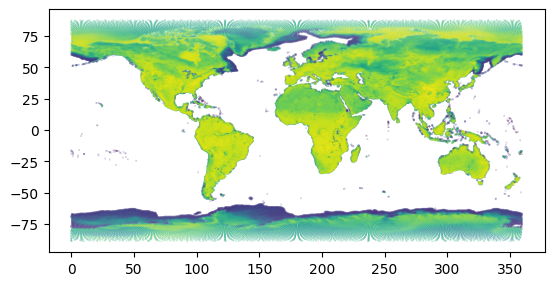

In [6]:
gdf.plot("Emis37H", s=0.01)

In [7]:
# Calculate the full grid with the same formula, not just the available cells
# Longitude points per latitude
ncells_per_lat = atlas.ncells

res_lat = 0.25
lat_band_number = 720

coordinates = []
for i in range(lat_band_number):
    for j in range(atlas.ncells[i]):
        lat = (i - 0.50) * res_lat - 90
        lon = (j - 0.5) * (360 / atlas.ncells[i])

        coordinates.append((lon, lat))

print(len(coordinates))

660066


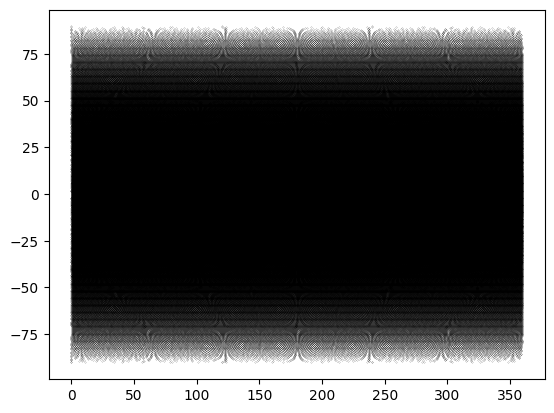

In [8]:
# unravel and check that we have all the coordinates:
import matplotlib.pyplot as plt

lons = [(coord[0] + 180) % 360 for coord in coordinates]
lats = [coord[1] for coord in coordinates]
# Correct the longitudes so GM = 180
plt.scatter(lons, lats, c="black", s=0.01)

### TODO: create a gridded version of the data

In [9]:
import geopandas as gp
import xarray as xr
import numpy as np

filename = (
    r"..\data\processed\GeoTelsem\ssmi_mean_emis_climato_01_cov_interpol_M2.geojson"
)
gdf = gp.read_file(filename)

In [10]:
gdf

,Emis19V,Emis19H,Emis22V,Emis37V,Emis37H,Emis85V,Emis85H,VarEmis19V,VarEmis19H,VarEmis22V,VarEmis37V,VarEmis37H,VarEmis85V,VarEmis85H,Surface_class1,Surface_class2,geometry
0,0.851150,0.694974,0.852954,0.860778,0.742279,0.821671,0.757044,0.013153,0.011402,0.013528,0.009487,0.014799,0.032249,0.028931,6,21,POINT (195.42857 -88.87500)
1,0.850715,0.694205,0.852940,0.862427,0.742945,0.830328,0.764085,0.013266,0.011533,0.013675,0.009798,0.014629,0.028775,0.027550,6,21,POINT (205.71429 -88.87500)
2,0.848923,0.688440,0.850987,0.862822,0.738313,0.845982,0.776129,0.013748,0.011874,0.014107,0.010630,0.014248,0.022000,0.024145,6,21,POINT (216.00000 -88.87500)
3,0.848579,0.684609,0.849558,0.860756,0.732303,0.853847,0.782463,0.014283,0.012490,0.014663,0.011269,0.014213,0.017029,0.021772,6,21,POINT (226.28571 -88.87500)
4,0.849775,0.683814,0.849110,0.857601,0.727091,0.856796,0.785715,0.014933,0.013638,0.015330,0.011832,0.014765,0.013491,0.020421,6,21,POINT (236.57143 -88.87500)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227138,0.923250,0.853500,0.895250,0.793000,0.741750,0.741500,0.717250,0.023749,0.027495,0.021471,0.023195,0.023388,0.026211,0.020050,7,16,POINT (149.43396 87.62500)
227139,0.914857,0.833714,0.883143,0.778571,0.719571,0.728857,0.693571,0.032772,0.043543,0.033615,0.035285,0.041437,0.052612,0.053198,7,16,POINT (156.22642 87.62500)
227140,0.919850,0.833513,0.890109,0.780906,0.717361,0.731695,0.693844,0.024920,0.034103,0.025826,0.031780,0.037470,0.048456,0.051010,7,16,POINT (163.01887 87.62500)
227141,0.931400,0.842800,0.901800,0.787400,0.722200,0.726600,0.691800,0.012124,0.015297,0.008775,0.019131,0.025159,0.037000,0.045727,7,16,POINT (169.81132 87.62500)


In [2]:
# Geopandas inbluilt finction
projection = "EPSG:4326"
reprojected_gdf = gdf.to_crs(projection)

# Create the array:
grid_size = 0.1

# Grid boundaries based on the extent of the reprojected GeoDataFrame
min_x, min_y, max_x, max_y = reprojected_gdf.total_bounds
x_bins = np.arange(min_x, max_x + grid_size, grid_size)
y_bins = np.arange(min_y, max_y + grid_size, grid_size)

# Initialize an empty array to hold aggregated values
array_shape = (len(y_bins), len(x_bins))  # shape of the array
array = np.zeros(array_shape)
print(array.shape)

(1766, 3601)


In [ ]:
# Aggregate points into grid cells
for index, row in reprojected_gdf.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    # Find the indices of the grid cell where the point falls
    x_index = np.searchsorted(x_bins, x, side="right") - 1
    y_index = np.searchsorted(y_bins, y, side="right") - 1
    # Increment the corresponding array element
    array[y_index, x_index] = row["Emis37H"]

In [5]:
# TODO: Bilinear interpolation to create the projected array

import geopandas as gpd
import numpy as np

# Choose the EPSG code for the Equirectangular projection
target_crs = "EPSG:4326"

# Project the GeoDataFrame to the Equirectangular projection
reprojected_gdf = gdf.to_crs(target_crs)

# Define the desired shape of the array
desired_shape = (720, 1440)

# Calculate the extent of the reprojected GeoDataFrame
min_x, min_y, max_x, max_y = reprojected_gdf.total_bounds

# Calculate the width and height of each pixel in the array
pixel_width = (max_x - min_x) / desired_shape[1]
pixel_height = (max_y - min_y) / desired_shape[0]

# Create a meshgrid of x and y coordinates
x_coords = np.linspace(
    min_x + pixel_width / 2, max_x - pixel_width / 2, desired_shape[1]
)
y_coords = np.linspace(
    min_y + pixel_height / 2, max_y - pixel_height / 2, desired_shape[0]
)
xx, yy = np.meshgrid(x_coords, y_coords)

# Now you have a meshgrid of coordinates in the Equirectangular projection
# You can use these coordinates to sample the values from your GeoDataFrame or perform other operations

In [11]:
# from scipy.interpolate import RectBivariateSpline

# # Define a function to perform bilinear interpolation
# def bilinear_interpolation(x, y, value, x_bins, y_bins):
#     # Create a 2D array to mimic a grid with only one value
#     values_grid = np.array([[value]])
#     interp_func = RectBivariateSpline(y_bins, x_bins, values_grid, kx=1, ky=1)
#     return interp_func(y, x)[0, 0]

# # Initialize the array to hold interpolated values
# array = np.zeros(desired_shape)

# # Perform bilinear interpolation for each point in the GeoDataFrame
# for index, row in reprojected_gdf.iterrows():
#     x = row.geometry.x
#     y = row.geometry.y
#     value = row['Emis37H']  # Replace 'Emis37H' with your column name

#     # Perform bilinear interpolation to get the value at the point's location
#     interpolated_value = bilinear_interpolation(x, y, value, x_coords, y_coords)

#     # Find the indices of the grid cell where the point falls
#     x_index = np.searchsorted(x_coords, x, side='right') - 1
#     y_index = np.searchsorted(y_coords, y, side='right') - 1

#     # Assign the interpolated value to the corresponding pixel in the array
#     array[y_index, x_index] = interpolated_value

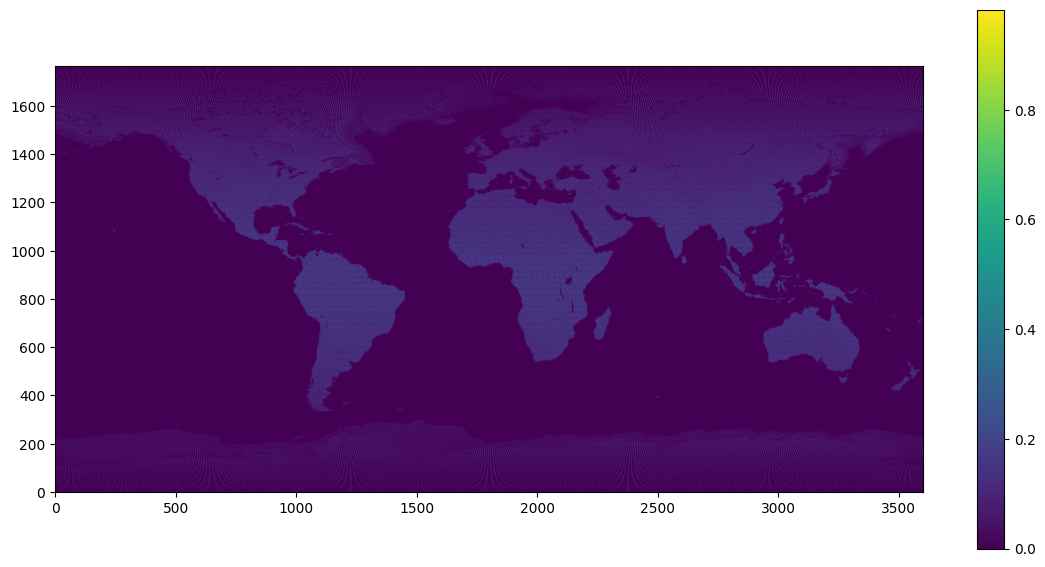

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.imshow(array, origin="lower")
plt.colorbar()

## Interpolation port to python
#### Using chat GPT to translate subtroutines to python functions. Needs revision


In [53]:
# Helper functions:
def calc_cellnum_mult(lat, lon, resol, atlas):
    # Function to compute cell numbers given the latitude, longitude, and resolution
    cell_num_mult = []
    nb_cell = 0

    # Calculate the cellnum in the older file
    ilat = min(int((lat + 90.0) / atlas.dlat) + 1, len(atlas.ncells))
    ilon = int(lon / (360.0 / atlas.ncells[ilat - 1])) + 1
    calc_cellnum = sum(atlas.ncells[: ilat - 1]) + ilon

    # Search for the nbcel pixels that are in the box of resolution 'resol' around lat and lon
    maxlat = 180.0 / atlas.dlat
    nbcel = 1
    cell = [calc_cellnum]
    nbreslat = int(resol / atlas.dlat / 2.0)

    if nbreslat >= 1:
        for i2lat in range(ilat - nbreslat, ilat + nbreslat + 1):
            if 1 <= i2lat <= int(maxlat):
                if abs((i2lat - 0.5) * atlas.dlat - 90 - lat) <= resol / 2.0:
                    i2lon = int(lon / (360.0 / atlas.ncells[i2lat - 1])) + 1
                    nbreslon = int(
                        resol / (360.0 / (1.0 * atlas.ncells[i2lat - 1])) / 2.0
                    )

                    for i3lon in range(i2lon - nbreslon, i2lon + nbreslon + 1):
                        if (
                            np.mod(
                                np.abs(
                                    (i3lon - 0.5) * (360.0 / atlas.ncells[i2lat - 1])
                                    - lon
                                ),
                                360.0,
                            )
                            <= resol / 2.0
                        ):
                            nbcel += 1
                            i4lon = i3lon
                            if i3lon < 1:
                                i4lon = atlas.ncells[i2lat - 1] + i3lon
                            if i3lon >= atlas.ncells[i2lat - 1]:
                                i4lon = i3lon - atlas.ncells[i2lat - 1]
                            new_cell = atlas.firstcell[i2lat - 1] + i4lon - 1
                            if new_cell != cell[0]:
                                cell.append(new_cell)

    nb_cell = nbcel
    cell_num_mult = np.array(cell, dtype=int)

    return cell_num_mult, nb_cell


def interp_freq2(emiss19, emiss37, emiss85, f, class2):
    # Linear interpolation of emissivity up to 85 GHz
    # Frequency interpolation above 85 GHz only for classes 10 to 13 (water-like classes)
    rapport43_32 = [0.62, 0.37, 0.46, 0.63]
    rapport54_43 = [0.30, 0.60, 0.47, 0.35]

    if f <= 19.35:
        a = 1
        b = 0
        c = 0
        emiss = emiss19
    elif f <= 37:
        a = (37 - f) / (37 - 19.35)
        b = (f - 19.35) / (37 - 19.35)
        c = 0
        emiss = a * emiss19 + b * emiss37
    elif f < 85.5:
        a = 0
        b = (85.5 - f) / (85.5 - 37)
        c = (f - 37) / (85.5 - 37)
        emiss = b * emiss37 + c * emiss85
    else:
        a = 0
        b = 0
        c = 1
        emiss = emiss85
        if 9 < class2 < 14 and emiss85 > emiss37:
            if f <= 150:
                emiss = (
                    emiss85
                    + (f - 85.5)
                    * ((emiss85 - emiss37) / (85.5 - 37))
                    * rapport43_32[class2 - 10]
                )
            elif f <= 190:
                emiss = (
                    emiss85
                    + (150 - 85.5)
                    * ((emiss85 - emiss37) / (85.5 - 37))
                    * rapport43_32[class2 - 10]
                )
                emiss += (
                    (f - 150)
                    * ((emiss - emiss85) / (150 - 85.5))
                    * rapport54_43[class2 - 10]
                )
            else:
                emiss = (
                    emiss85
                    + (150 - 85.5)
                    * ((emiss85 - emiss37) / (85.5 - 37))
                    * rapport43_32[class2 - 10]
                )
                emiss += (
                    (190 - 150)
                    * ((emiss - emiss85) / (150 - 85.5))
                    * rapport54_43[class2 - 10]
                )
            if emiss > 1:
                emiss = 1

    return emiss, a, b, c


def data_string_to_array(data_string: str) -> np.array:
    """Reads the fortran string representation of the data and returns a numpy array"""
    _, data, _ = data_string.split("/")

    lines = data.replace("\n", "").split("&")
    lines = [l.strip() for l in lines if l.strip()]

    raw_array = []
    for line in lines:
        data_values = line.split(",")
        data_values = [
            float(value.split("_")[0]) for value in data_values if value.strip()
        ]
        raw_array.append(data_values)

    return np.array(raw_array)


def emis_interp(theta, freq, class1, class2, ev, eh):
    # Coefficients
    a0_k0 = data_string_to_array(
        """ 
        data a0_k0/0.11509_jprb,0.091535_jprb,0.34796_jprb,0.10525_jprb,0.16627_jprb,0.24434_jprb, &
         & 0.29217_jprb,0.23809_jprb,0.28954_jprb,0.17516_jprb,0.19459_jprb,0.28697_jprb, &
         & 0.10521_jprb,0.12126_jprb,0.30278_jprb,0.18212_jprb,0.19625_jprb,0.14551_jprb, &
         & -0.19202_jprb,0.5411_jprb,0.03739_jprb,0.10292_jprb,0.5486_jprb,-0.058937_jprb, &
         & -0.022672_jprb,0.44492_jprb,-0.058448_jprb,-0.33894_jprb,-0.17621_jprb,0.14742_jprb/
        """
    )
    a0_k1 = data_string_to_array(
        """
        data a0_k1/0.61168_jprb,0.59095_jprb,0.7918_jprb,0.60271_jprb,0.69213_jprb,0.62218_jprb, &
         &  0.32728_jprb,0.34334_jprb,0.37062_jprb,0.51217_jprb,0.4491_jprb,0.50101_jprb, &
         & 0.48913_jprb,0.41932_jprb,0.29734_jprb,0.64474_jprb,0.30637_jprb,0.031107_jprb, &
         & 1.0405_jprb,0.17538_jprb,1.3215_jprb,0.61819_jprb,0.31298_jprb,1.7218_jprb, &
         & 0.87761_jprb,0.47583_jprb,1.2583_jprb,1.0959_jprb,0.92842_jprb,0.51033_jprb/
        """
    )
    a0_k2 = data_string_to_array(
        """ 
        data a0_k2/0.26726_jprb,0.32033_jprb,-0.14778_jprb,0.28547_jprb,0.13592_jprb,0.13193_jprb, &
         & 0.37178_jprb,0.41813_jprb,0.33875_jprb,0.30203_jprb,0.35479_jprb,0.20189_jprb, &
         & 0.40663_jprb,0.47493_jprb,0.40668_jprb,0.14811_jprb,0.52382_jprb,0.86634_jprb, &
         & 0.14286_jprb,0.27164_jprb,-0.37947_jprb,0.2737_jprb,0.12001_jprb,-0.67315_jprb, &
         & 0.13492_jprb,0.065463_jprb,-0.19316_jprb,0.24905_jprb,0.25475_jprb,0.34637_jprb/
    
        """
    )
    a0_eveh = data_string_to_array(
        """ 
        data a0_eveh/0.9592599869E+00_jprb,0.9565299749E+00_jprb,0.9511899948E+00_jprb, &
         & 0.9560700059E+00_jprb,0.9541199803E+00_jprb,0.9483199716E+00_jprb, &
         & 0.9461100101E+00_jprb,0.9439799786E+00_jprb,0.9387800097E+00_jprb, &
         & 0.9317600131E+00_jprb,0.9289000034E+00_jprb,0.9236800075E+00_jprb, &
         & 0.9208700061E+00_jprb,0.9190599918E+00_jprb,0.9105200171E+00_jprb, &
         & 0.9162799716E+00_jprb,0.8937299848E+00_jprb,0.8014699817E+00_jprb, &
         & 0.9570500255E+00_jprb,0.9213600159E+00_jprb,0.7893999815E+00_jprb, &
         & 0.9639400244E+00_jprb,0.9530599713E+00_jprb,0.8850200176E+00_jprb, &
         & 0.9685299993E+00_jprb,0.9622600079E+00_jprb,0.9118800163E+00_jprb, &
         & 0.8997200131E+00_jprb,0.9012699723E+00_jprb,0.9107499719E+00_jprb/
    
        """
    )
    a1_eveh = data_string_to_array(
        """ 
        data a1_eveh/0.3627802414E-07_jprb,-0.7778328204E-08_jprb,0.4396108011E-07_jprb, &
         & 0.2503205394E-06_jprb,0.1996262995E-06_jprb,0.2929977541E-06_jprb, &
         & 0.4190530660E-06_jprb,0.3655744649E-06_jprb,0.3519195673E-06_jprb, &
         & 0.5574374313E-06_jprb,0.5273076340E-06_jprb,0.5376484182E-06_jprb, &
         & 0.1026844529E-05_jprb,0.9679998811E-06_jprb,0.8616486866E-06_jprb, &
         & 0.3180800832E-06_jprb,0.2886778532E-06_jprb,0.2310362675E-06_jprb, &
         & -0.1118036366E-06_jprb,-0.1502856577E-06_jprb,0.4842232926E-07_jprb, &
         & -0.8410978580E-08_jprb,-0.3478669441E-07_jprb,0.2209441590E-06_jprb, &
         & 0.2485776633E-06_jprb,0.1800235907E-06_jprb,0.2510202251E-06_jprb, &
         & 0.2687000915E-06_jprb,0.1740325644E-06_jprb,0.3562134339E-06_jprb/
        """
    )
    a2_eveh = data_string_to_array(
        """
        data a2_eveh/0.3067140824E-05_jprb,0.2520012231E-05_jprb,0.4831396382E-05_jprb, &
         & 0.8213598448E-05_jprb,0.7378375358E-05_jprb,0.1022081960E-04_jprb, &
         & 0.1225889173E-04_jprb,0.1165553113E-04_jprb,0.1188659007E-04_jprb, &
         & 0.1693615741E-04_jprb,0.1648317448E-04_jprb,0.1715818144E-04_jprb, &
         & 0.2744720041E-04_jprb,0.2642072104E-04_jprb,0.2671847506E-04_jprb, &
         & 0.1349592094E-04_jprb,0.1261523357E-04_jprb,0.5447756394E-05_jprb, &
         & 0.2064244654E-05_jprb,0.1919016057E-06_jprb,0.5940860319E-06_jprb, &
         & 0.5334760772E-05_jprb,0.4130339221E-05_jprb,0.4104662821E-05_jprb, &
         & 0.6530796327E-05_jprb,0.5727014013E-05_jprb,0.7451782039E-05_jprb, &
         & 0.1071246970E-04_jprb,0.9539280654E-05_jprb,0.1034286015E-04_jprb/
        """
    )
    a3_eveh = data_string_to_array(
        """ 
        data a3_eveh/-0.2004991551E-07_jprb,-0.6895366056E-07_jprb, -0.2047409282E-06_jprb, &
         & -0.7322448425E-07_jprb,-0.1273002681E-06_jprb,-0.2729916844E-06_jprb, &
         & -0.9421125213E-07_jprb,-0.1683332300E-06_jprb,-0.2726891637E-06_jprb, &
         & -0.1317753799E-06_jprb,-0.2107972250E-06_jprb,-0.3556060904E-06_jprb, &
         & -0.1889465580E-06_jprb,-0.2757958271E-06_jprb,-0.4909850304E-06_jprb, &
         & 0.7339644004E-08_jprb,-0.4058669560E-06_jprb,-0.4146343997E-06_jprb, &
         & 0.6170279931E-07_jprb,-0.1998567996E-06_jprb,-0.4713119139E-07_jprb, &
         & -0.1361754887E-07_jprb,-0.1765622955E-06_jprb,-0.2348146637E-06_jprb, &
         & -0.3901189061E-07_jprb,-0.1305666189E-06_jprb,-0.1533838798E-06_jprb, &
         & -0.2679148992E-07_jprb,-0.4441960044E-07_jprb,-0.1815613899E-06_jprb/
        """
    )
    b0_eveh = data_string_to_array(
        """ 
        data b0_eveh/0.9592599869E+00_jprb,0.9565299749E+00_jprb,0.9511899948E+00_jprb, &
         & 0.9560700059E+00_jprb,0.9541199803E+00_jprb,0.9483199716E+00_jprb, &
         & 0.9461100101E+00_jprb,0.9439799786E+00_jprb,0.9387800097E+00_jprb, &
         & 0.9317600131E+00_jprb,0.9289000034E+00_jprb,0.9236800075E+00_jprb, &
         & 0.9208700061E+00_jprb,0.9190599918E+00_jprb,0.9105200171E+00_jprb, &
         & 0.9162799716E+00_jprb,0.8937299848E+00_jprb,0.8014699817E+00_jprb, &
         & 0.9570500255E+00_jprb,0.9213600159E+00_jprb,0.7893999815E+00_jprb, &
         & 0.9639400244E+00_jprb,0.9530599713E+00_jprb,0.8850200176E+00_jprb, &
         & 0.9685299993E+00_jprb,0.9622600079E+00_jprb,0.9118800163E+00_jprb, &
         & 0.8997200131E+00_jprb,0.9012699723E+00_jprb,0.9107499719E+00_jprb/
        """
    )
    b1_eveh = data_string_to_array(
        """ 
        data b1_eveh/0.3626608347E-07_jprb,-0.7786279177E-08_jprb,0.4393379172E-07_jprb, &
         & 0.2502746099E-06_jprb,0.1995944388E-06_jprb,0.2929554341E-06_jprb, &
         & 0.4189516289E-06_jprb,0.3655020180E-06_jprb,0.3518483140E-06_jprb, &
         & 0.5572838404E-06_jprb,0.5271903092E-06_jprb,0.5375342766E-06_jprb, &
         & 0.1026605219E-05_jprb,0.9677979733E-06_jprb,0.8614680951E-06_jprb, &
         & 0.3179358714E-06_jprb,0.2884899004E-06_jprb,0.2308632219E-06_jprb, &
         & -0.1118781370E-06_jprb,-0.1503948681E-06_jprb,0.4834672396E-07_jprb, &
         & -0.8455684153E-08_jprb,-0.3485171618E-07_jprb,0.2208606134E-06_jprb, &
         & 0.2485595019E-06_jprb,0.1799959364E-06_jprb,0.2509846695E-06_jprb, &
         & 0.2686167306E-06_jprb,0.1739760478E-06_jprb,0.3561317214E-06_jprb/
        """
    )
    b2_eveh = data_string_to_array(
        """ 
        data b2_eveh/0.3065537157E-05_jprb,0.2518960400E-05_jprb,0.4829731552E-05_jprb, &
         & 0.8209894986E-05_jprb,0.7375769655E-05_jprb,0.1021809931E-04_jprb, &
         & 0.1225203869E-04_jprb,0.1165053800E-04_jprb,0.1188218721E-04_jprb, &
         & 0.1692612022E-04_jprb,0.1647546378E-04_jprb,0.1715117833E-04_jprb, &
         & 0.2743142431E-04_jprb,0.2640772436E-04_jprb,0.2670711910E-04_jprb, &
         & 0.1348545720E-04_jprb,0.1260529825E-04_jprb,0.5439695997E-05_jprb, &
         & 0.2058213340E-05_jprb,0.1860650656E-06_jprb,0.5898303925E-06_jprb, &
         & 0.5330772183E-05_jprb,0.4126528893E-05_jprb,0.4100859314E-05_jprb, &
         & 0.6528573977E-05_jprb,0.5725009032E-05_jprb,0.7449450095E-05_jprb, &
         & 0.1070590315E-04_jprb,0.9534271157E-05_jprb,0.1033751869E-04_jprb/
        """
    )
    b3_eveh = data_string_to_array(
        """ 
        data b3_eveh/-0.1370247134E-06_jprb,-0.1436897747E-06_jprb, -0.2954870411E-06_jprb, &
         & -0.3118435643E-06_jprb,-0.2916583242E-06_jprb,-0.4311032171E-06_jprb, &
         & -0.5048401022E-06_jprb,-0.4662823869E-06_jprb,-0.5206445053E-06_jprb, &
         & -0.7210980471E-06_jprb,-0.6662896794E-06_jprb,-0.7548637200E-06_jprb, &
         & -0.1110204039E-05_jprb,-0.1030801400E-05_jprb,-0.1140921199E-05_jprb, &
         & -0.6330818110E-06_jprb,-0.9186441048E-06_jprb,-0.7947813856E-06_jprb, &
         & -0.3242539890E-06_jprb,-0.5027602583E-06_jprb,-0.2777987334E-06_jprb, &
         & -0.2747250676E-06_jprb,-0.3811997260E-06_jprb,-0.4102405455E-06_jprb, &
         & -0.1994112324E-06_jprb,-0.2555484855E-06_jprb,-0.2842682534E-06_jprb, &
         & -0.4413041665E-06_jprb,-0.3717419474E-06_jprb,-0.4975536854E-06_jprb/
        """
    )

    # Interpolation in angle
    emiss_scal_v = np.zeros(3)
    emiss_scal_h = np.zeros(3)
    for j in range(3):
        e0 = a0_k0[j, class1] + a0_k1[j, class1] * ev[j] + a0_k2[j, class1] * eh[j]
        a0 = a0_eveh[j, class1]
        a1 = a1_eveh[j, class1]
        a2 = a2_eveh[j, class1]
        a3 = a3_eveh[j, class1]
        b0 = b0_eveh[j, class1]
        b1 = b1_eveh[j, class1]
        b2 = b2_eveh[j, class1]
        b3 = b3_eveh[j, class1]
        theta0 = 0.0
        theta53 = 53.0
        # Vertical polarization
        S1_v = ((theta - theta53) / (theta0 - theta53)) * ((e0 - a0) / a0)
        em53_v = a3 * (theta53**3) + a2 * (theta53**2) + a1 * theta53 + a0
        S2_v = ((theta - theta0) / (theta53 - theta0)) * ((ev[j] - em53_v) / em53_v)
        S_v = 1 + S1_v + S2_v
        emtheta_v = a3 * (theta**3) + a2 * (theta**2) + a1 * theta + a0
        emiss_scal_v[j] = S_v * emtheta_v
        # Horizontal polarization
        S1_h = ((theta - theta53) / (theta0 - theta53)) * ((e0 - b0) / b0)
        em53_h = b3 * (theta53**3) + b2 * (theta53**2) + b1 * theta53 + b0
        S2_h = ((theta - theta0) / (theta53 - theta0)) * ((eh[j] - em53_h) / em53_h)
        S_h = 1 + S1_h + S2_h
        emtheta_h = b3 * (theta**3) + b2 * (theta**2) + b1 * theta + b0
        emiss_scal_h[j] = S_h * emtheta_h

    # Interpolation in frequency
    emiss_interp_v = interp_freq2(
        emiss_scal_v[0], emiss_scal_v[1], emiss_scal_v[2], freq, class2
    )
    emiss_interp_h = interp_freq2(
        emiss_scal_h[0], emiss_scal_h[1], emiss_scal_h[2], freq, class2
    )

    # Case ev<eh: take the average between the two
    if emiss_interp_v < emiss_interp_h:
        emiss_interp_v = (emiss_interp_v + emiss_interp_h) / 2.0
        emiss_interp_h = emiss_interp_v

    emiss_interp_h = min(1.0, emiss_interp_h)
    emiss_interp_v = min(1.0, emiss_interp_v)

    return emiss_interp_v, emiss_interp_h

In [40]:
# Testing parser for the data in the module
data_string_to_array(
    """ data a0_k0/0.11509_jprb,0.091535_jprb,0.34796_jprb,0.10525_jprb,0.16627_jprb,0.24434_jprb, &
         & 0.29217_jprb,0.23809_jprb,0.28954_jprb,0.17516_jprb,0.19459_jprb,0.28697_jprb, &
         & 0.10521_jprb,0.12126_jprb,0.30278_jprb,0.18212_jprb,0.19625_jprb,0.14551_jprb, &
         & -0.19202_jprb,0.5411_jprb,0.03739_jprb,0.10292_jprb,0.5486_jprb,-0.058937_jprb, &
         & -0.022672_jprb,0.44492_jprb,-0.058448_jprb,-0.33894_jprb,-0.17621_jprb,0.14742_jprb/
    """
)

array([[ 0.11509 ,  0.091535,  0.34796 ,  0.10525 ,  0.16627 ,  0.24434 ],
       [ 0.29217 ,  0.23809 ,  0.28954 ,  0.17516 ,  0.19459 ,  0.28697 ],
       [ 0.10521 ,  0.12126 ,  0.30278 ,  0.18212 ,  0.19625 ,  0.14551 ],
       [-0.19202 ,  0.5411  ,  0.03739 ,  0.10292 ,  0.5486  , -0.058937],
       [-0.022672,  0.44492 , -0.058448, -0.33894 , -0.17621 ,  0.14742 ]])

In [56]:
# Single cell, single channel:

import numpy as np


def emis_interp_int_sing(lat, lon, resol, theta, freq, atlas, verb=0):
    # Function to calculate emissivity interpolation for a single channel from an atlas class
    ev = 0
    eh = 0
    stdv = 0
    stdh = 0
    covvh = 0

    # Initializations
    stdd = np.zeros(3)
    ev_mean = 0
    eh_mean = 0
    std_mean = np.zeros((2, 2))
    inumb = 0

    # Compute the list of cells that need to be integrated in the atlas
    cellnum_mult, nb_cell = calc_cellnum_mult(lat, lon % 360.0, resol, atlas)

    for ii in range(1, nb_cell):
        ipos = atlas.correspondance[cellnum_mult[ii - 1]]

        if ipos > 0:
            inumb += 1
            ev_a = [
                atlas.emis[ipos - 1, 0],
                atlas.emis[ipos - 1, 1],
                atlas.emis[ipos - 1, 3],
            ]
            eh_a = [
                atlas.emis[ipos - 1, 4],
                atlas.emis[ipos - 1, 5],
                atlas.emis[ipos - 1, 6],
            ]

            ev = 0
            eh = 0
            ev, eh = emis_interp(
                theta, freq, atlas.class1[ipos - 1], atlas.class2[ipos - 1], ev_a, eh_a
            )

            ev_mean += ev
            eh_mean += eh

            if stdv or stdh or covvh:
                # Compute covariance matrix on the atlas frequencies
                cov = np.zeros((6, 6))
                for i in range(1, 7):
                    i2 = i + 1 if i > 2 else i
                    for j in range(1, 7):
                        j2 = j + 1 if j > 2 else j
                        cov[i - 1, j - 1] = atlas.correl[
                            atlas.class1[ipos - 1], i2, j2
                        ] * (
                            atlas.emis_err[ipos - 1, i2] * atlas.emis_err[ipos - 1, j2]
                        )

                # Compute the Frequency Linear Matrix
                a, b, c = interp_freq2(
                    stdd[0], stdd[1], stdd[2], freq, atlas.class2[ipos - 1]
                )
                FIM = np.zeros((2, 3 * 2))
                FIM[0, :3] = [a, b, c]
                FIM[1, 3:6] = [a, b, c]

                new_FIM = FIM.T
                trans_std = np.matmul(cov, new_FIM)
                std2 = np.matmul(FIM, trans_std)
                std_mean += std2

    if inumb > 0:
        ev = ev_mean / inumb
        eh = eh_mean / inumb

        if stdv:
            stdv = np.sqrt(std_mean[0, 0] / inumb)

        if stdh:
            stdh = np.sqrt(std_mean[1, 1] / inumb)

        if covvh:
            covvh = std_mean[0, 1] / inumb

    return ev, eh, stdv, stdh, covvh

In [58]:
atlas.coordinates

[(-88.875, 15.42857142857143),
 (-88.875, 25.714285714285715),
 (-88.875, 36.0),
 (-88.875, 46.28571428571429),
 (-88.875, 56.57142857142858),
 (-88.875, 66.85714285714286),
 (-88.875, 77.14285714285715),
 (-88.875, 87.42857142857143),
 (-88.875, 97.71428571428572),
 (-88.875, 108.00000000000001),
 (-88.875, 118.28571428571429),
 (-88.875, 128.57142857142858),
 (-88.875, 138.85714285714286),
 (-88.875, 149.14285714285717),
 (-88.875, 159.42857142857144),
 (-88.875, 169.71428571428572),
 (-88.875, 180.0),
 (-88.875, 190.2857142857143),
 (-88.875, 200.57142857142858),
 (-88.875, 210.85714285714286),
 (-88.875, 221.14285714285717),
 (-88.875, 231.42857142857144),
 (-88.875, 241.71428571428572),
 (-88.875, 252.00000000000003),
 (-88.875, 262.2857142857143),
 (-88.875, 272.5714285714286),
 (-88.875, 282.8571428571429),
 (-88.875, 293.14285714285717),
 (-88.875, 303.42857142857144),
 (-88.875, 313.7142857142857),
 (-88.875, 324.0),
 (-88.875, 334.28571428571433),
 (-88.875, 344.5714285714286

In [59]:
emis_interp_int_sing(
    lat=-88, lon=213, resol=0.25, theta=0.55, freq=19, atlas=atlas, verb=True
)

(0, 0, 0, 0, 0)

In [52]:
a1_eveh = data_string_to_array(
    """ 
        data a1_eveh/0.3627802414E-07_jprb,-0.7778328204E-08_jprb,0.4396108011E-07_jprb, &
         & 0.2503205394E-06_jprb,0.1996262995E-06_jprb,0.2929977541E-06_jprb, &
         & 0.4190530660E-06_jprb,0.3655744649E-06_jprb,0.3519195673E-06_jprb, &
         & 0.5574374313E-06_jprb,0.5273076340E-06_jprb,0.5376484182E-06_jprb, &
         & 0.1026844529E-05_jprb,0.9679998811E-06_jprb,0.8616486866E-06_jprb, &
         & 0.3180800832E-06_jprb,0.2886778532E-06_jprb,0.2310362675E-06_jprb, &
         & -0.1118036366E-06_jprb,-0.1502856577E-06_jprb,0.4842232926E-07_jprb, &
         & -0.8410978580E-08_jprb,-0.3478669441E-07_jprb,0.2209441590E-06_jprb, &
         & 0.2485776633E-06_jprb,0.1800235907E-06_jprb,0.2510202251E-06_jprb, &
         & 0.2687000915E-06_jprb,0.1740325644E-06_jprb,0.3562134339E-06_jprb/
        """
)
a1_eveh

array([[ 3.62780241e-08, -7.77832820e-09,  4.39610801e-08],
       [ 2.50320539e-07,  1.99626299e-07,  2.92997754e-07],
       [ 4.19053066e-07,  3.65574465e-07,  3.51919567e-07],
       [ 5.57437431e-07,  5.27307634e-07,  5.37648418e-07],
       [ 1.02684453e-06,  9.67999881e-07,  8.61648687e-07],
       [ 3.18080083e-07,  2.88677853e-07,  2.31036267e-07],
       [-1.11803637e-07, -1.50285658e-07,  4.84223293e-08],
       [-8.41097858e-09, -3.47866944e-08,  2.20944159e-07],
       [ 2.48577663e-07,  1.80023591e-07,  2.51020225e-07],
       [ 2.68700091e-07,  1.74032564e-07,  3.56213434e-07]])